## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

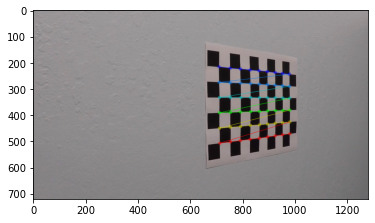

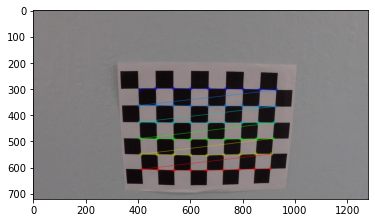

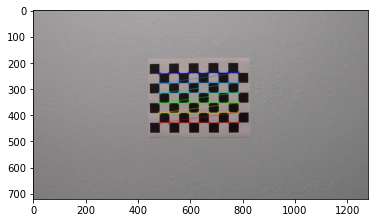

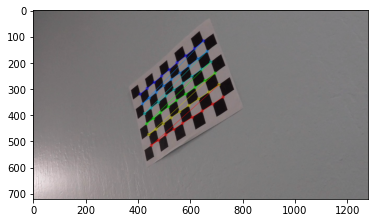

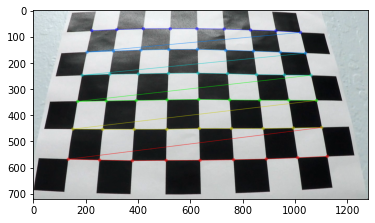

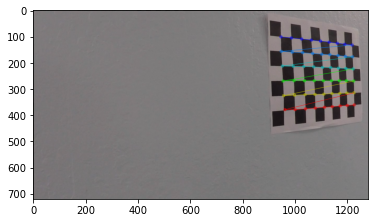

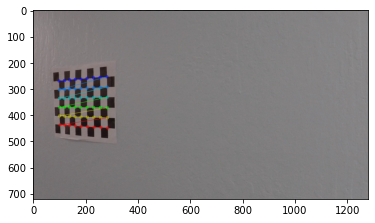

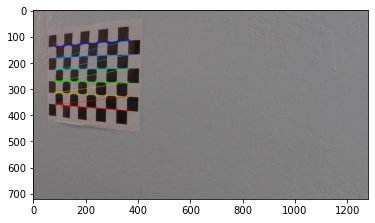

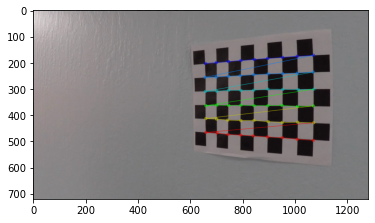

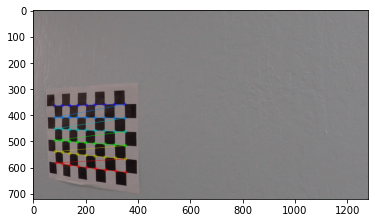

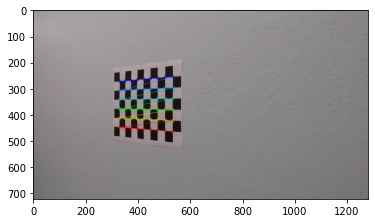

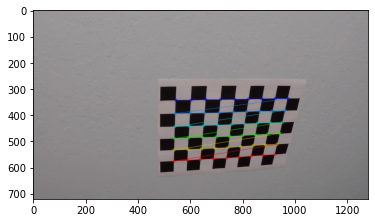

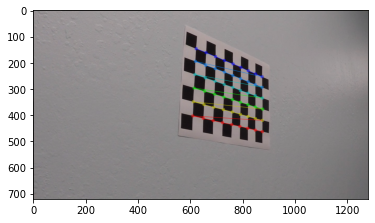

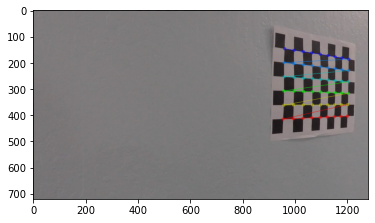

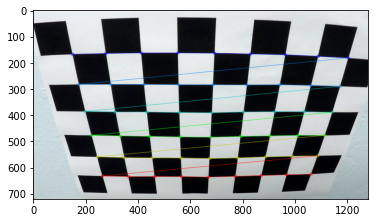

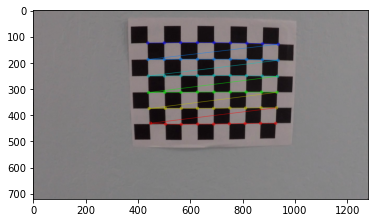

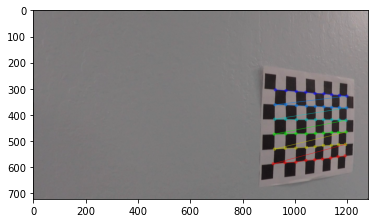

In [2]:
# Getting the calibration coefficients

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

## Distortion Correction
* Apply a distortion correction to raw images.

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
img = cv2.imread('./camera_cal/calibration1.jpg')

In [5]:
undistorted = cal_undistort(img, objpoints, imgpoints)

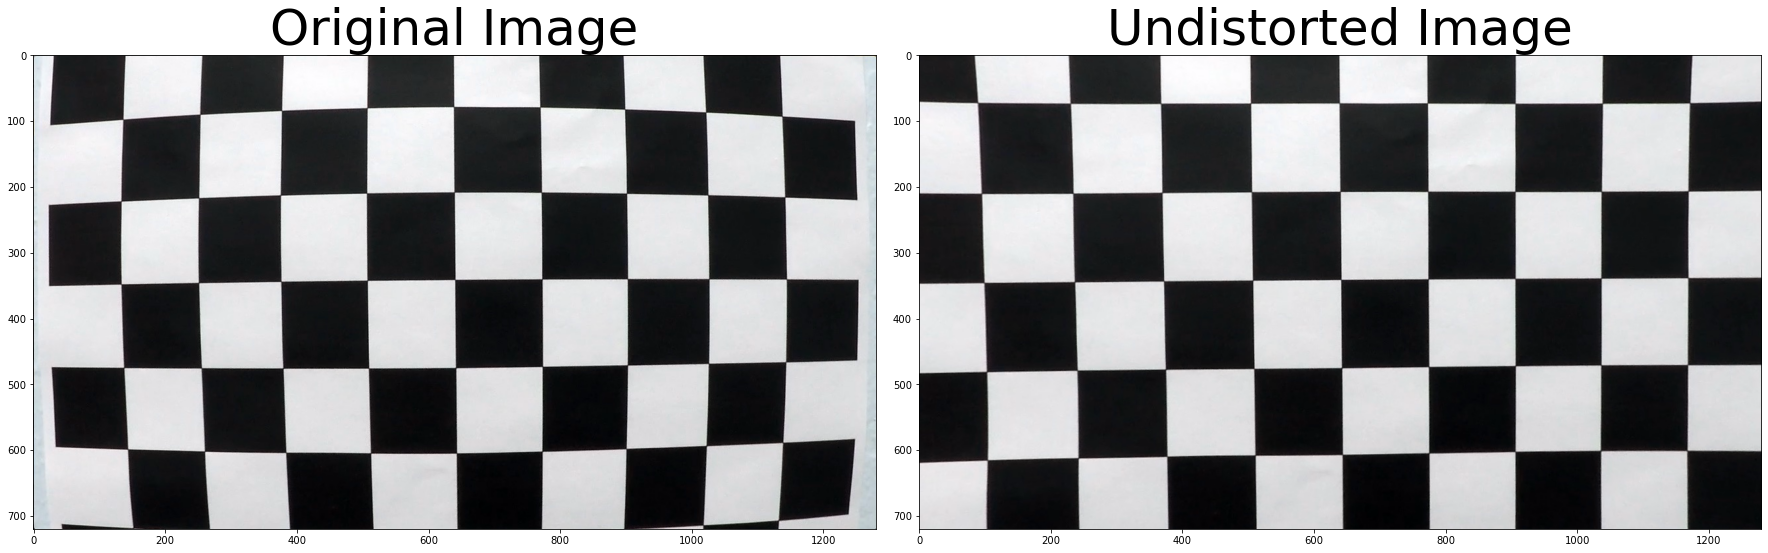

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

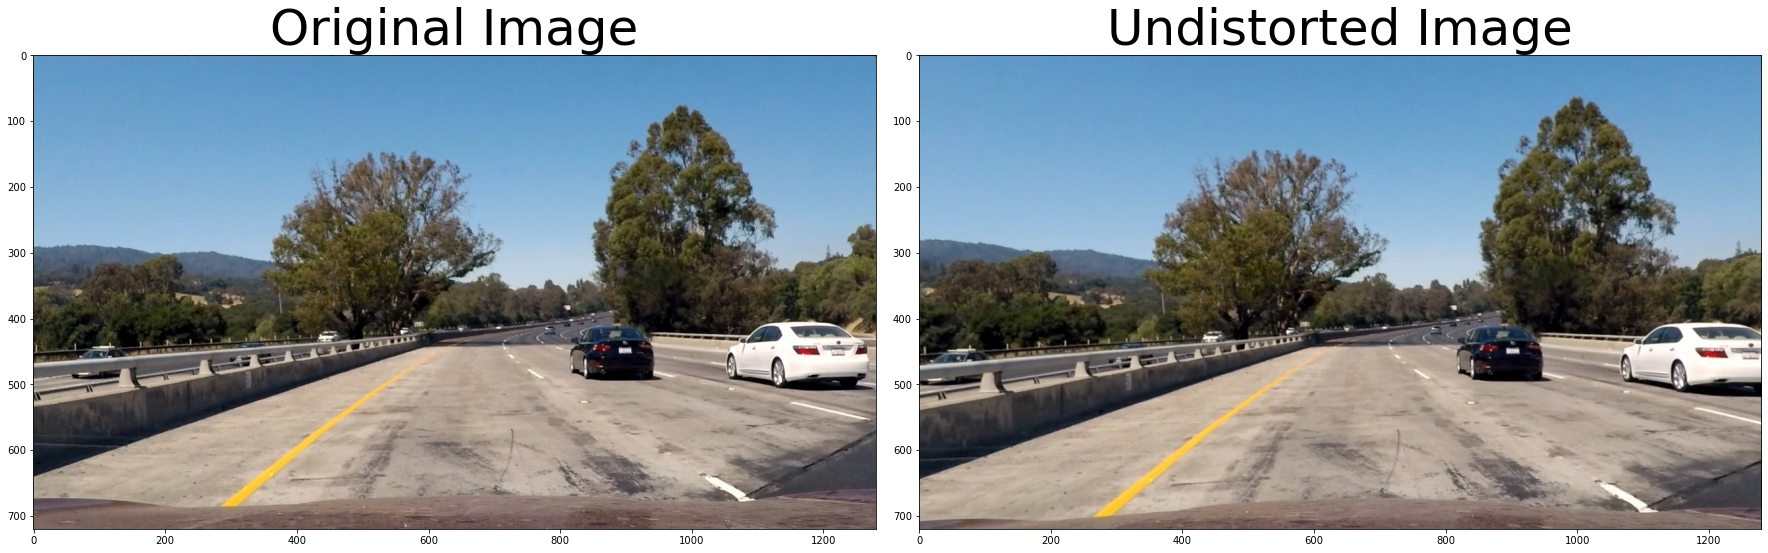

In [11]:
# Undistorting test image 1
# Read image test1.jpg
img = cv2.imread('./test_images/test1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistorting image
undistorted = cal_undistort(img_rgb, objpoints, imgpoints)

# Plotting result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# Saving output
plt.savefig('./output_images/undistorted_example.jpg')
plt.show()

## Color and Thresholds
* Use color transforms, gradients, etc., to create a thresholded binary image.

In [12]:
# Thresholds used to generate binary image based on filters like sobel, magnitude and direction

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Copying image
    gray = img.copy()
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Copying image
    gray = img.copy()
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255*magnitude/np.max(magnitude))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Copying image    
    gray = img.copy()
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(arctan)
    binary_output[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

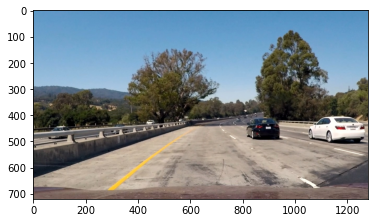

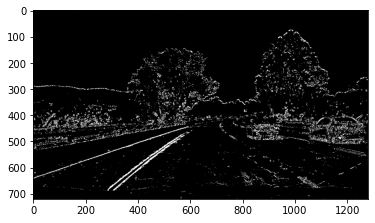

In [13]:
# First the binary with thresholding based on filters on the combination of the Channels S from HLS and R from RGB

def threshs(image_i, tipo='video'):
    
    if tipo == 'video':
        image = image_i.copy()
        a1 = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2]
        a2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:,0]
        added = cv2.addWeighted(a1, 0.5, a2, 0.5, 0.0)
        image = added.copy()
    else:
        image = cv2.imread(image_i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        a1 = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2]
        a2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:,0]
        added = cv2.addWeighted(a1, 0.5, a2, 0.5, 0.0)
        image = added.copy()
        
    # Thresholds testing
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.4))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

# Single img
i_test = threshs('./test_images/test1.jpg', 'imagem')
plt.imshow(i_test, cmap='gray')
plt.show()

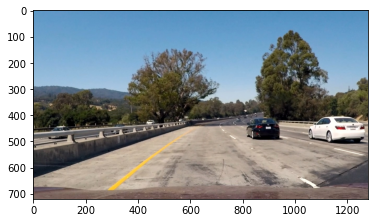

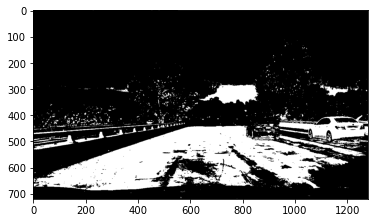

In [14]:
# Binary imaged based only on the Color Thresholding

def pipeline_binary(img_read, tipo='video'):
    
    if tipo == 'video':
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    
    else:
        # Read image on BGR
        img_read = cv2.imread(img_read)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
    
    # Uses HLS HSV RGB
    # Binary on R of RGB
    rgb_R = img_rgb[:,:,0]
    thresh_R = (170, 255)
    binary_R = np.zeros_like(rgb_R)
    binary_R[(rgb_R > thresh_R[0]) & (rgb_R <= thresh_R[1])] = 1
#     plt.imshow(binary_R)
#     plt.show()
    
    # Binary of S on HLS
    img_hls = cv2.cvtColor(img_read, cv2.COLOR_BGR2HLS)
    hls_S = img_hls[:,:,2]
    thresh_S = (170, 255)
    binary_S = np.zeros_like(hls_S)
    binary_S[(hls_S > thresh_S[0]) & (hls_S <= thresh_S[1])] = 1
#     plt.imshow(binary_S)
#     plt.show()

   
    # Combining
    processed_image = np.zeros_like(rgb_R)
    processed_image[(binary_S == 1) | (binary_R == 1)] = 1
    
    return processed_image

# Single img
b_test = pipeline_binary('./test_images/test1.jpg', 'imagem')
plt.imshow(b_test, cmap='gray')
plt.show()

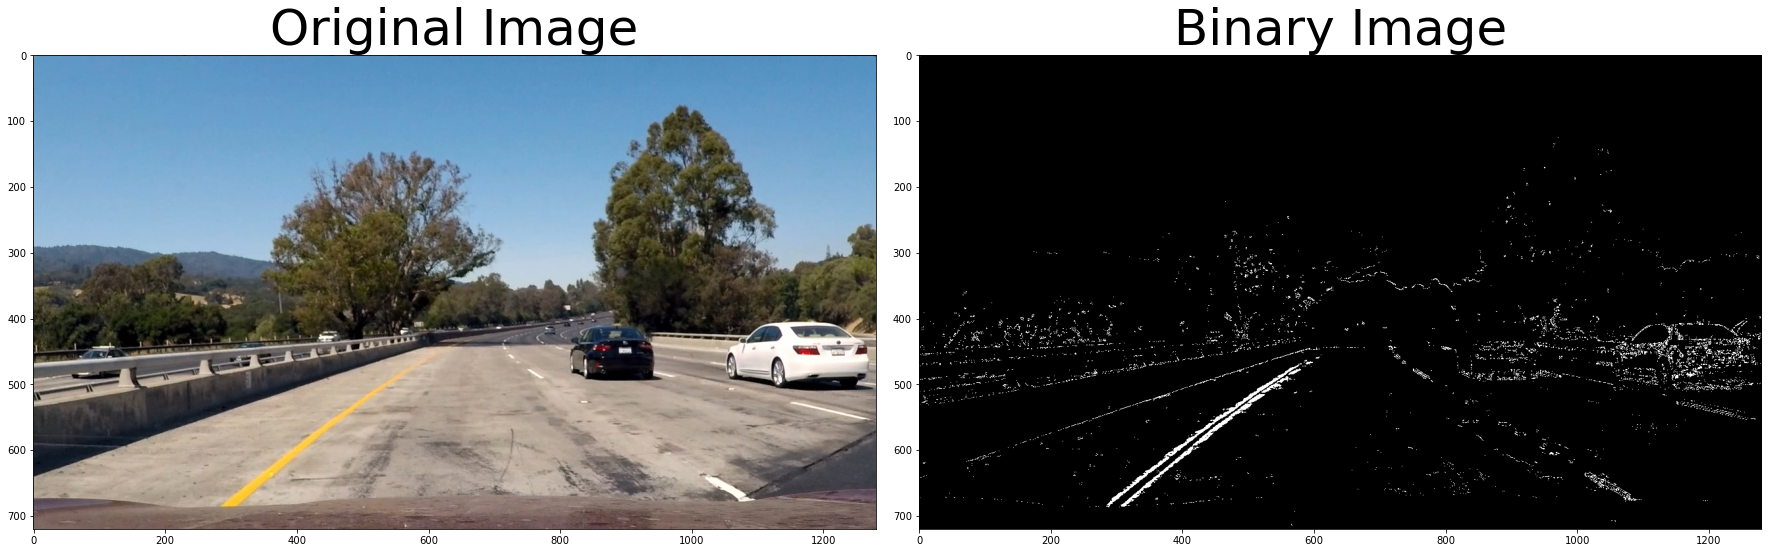

In [15]:
# The combination of Color and Filters Thresholds
# This proved to be the best to run on the challenge video as well

combined_binary = np.zeros_like(b_test)
combined_binary[(i_test == 1) & (b_test == 1)] = 1

# Plotting result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# Saving output
plt.savefig('./output_images/binary_image.jpg')
plt.show()

### Warping Image
* Apply a perspective transform to rectify binary image ("birds-eye view").

In [16]:
# Defining the warp function

def warp(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 50, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 55), img_size[1]],
        [(img_size[0] * 5 / 6) + 20, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

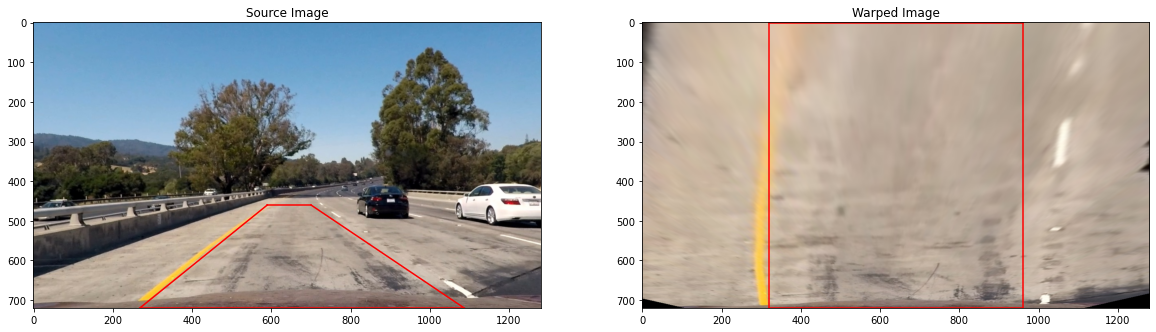

In [18]:
# Visualizing the undistorted warped image and plotting the points

warped_im, Minv = warp(undistorted)

img_size = warped_im.shape

P1 = [(img_size[1] / 2) - 50, img_size[0] / 2 + 100]
P2 = [(img_size[1] / 6) + 55, img_size[0]]
P3 = [(img_size[1] * 5 / 6) + 20, img_size[0]]
P4 = [(img_size[1] / 2 + 60), img_size[0] / 2 + 100]

D1 = [(img_size[1] / 4), 0]
D2 = [(img_size[1] / 4), img_size[0]]
D3 = [(img_size[1] * 3 / 4), img_size[0]]
D4 = [(img_size[1] * 3 / 4), 0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source Image')
ax1.plot([P1[0], P2[0]], [P1[1], P2[1]], c='r')
ax1.plot([P2[0], P3[0]], [P2[1], P3[1]], c='r')
ax1.plot([P3[0], P4[0]], [P3[1], P4[1]], c='r')
ax1.plot([P4[0], P1[0]], [P4[1], P1[1]], c='r')
ax1.imshow(undistorted)

ax2.set_title('Warped Image')
ax2.plot([D1[0], D2[0]], [D1[1], D2[1]], c='r')
ax2.plot([D2[0], D3[0]], [D2[1], D3[1]], c='r')
ax2.plot([D3[0], D4[0]], [D3[1], D4[1]], c='r')
ax2.plot([D4[0], D1[0]], [D4[1], D1[1]], c='r')
ax2.imshow(warped_im)
# Saving output
plt.savefig('./output_images/warped_example.jpg')
plt.show()

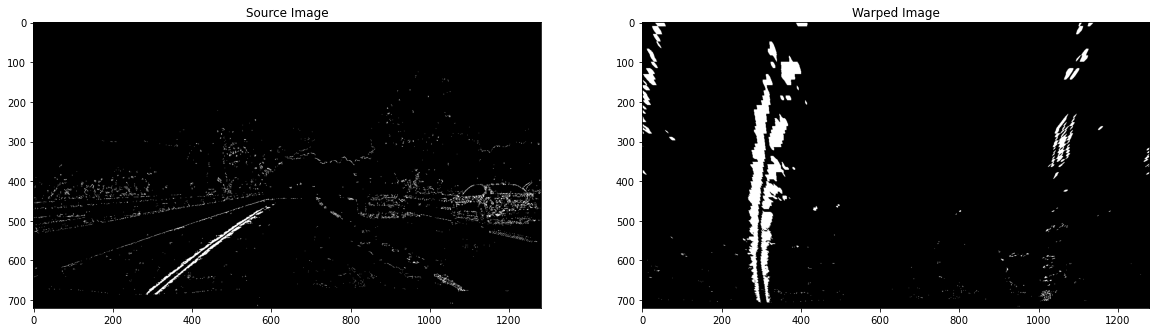

In [22]:
# Applying on a binary image
warped_im, Minv = warp(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source Image')
ax1.imshow(combined_binary, cmap='gray')
ax2.set_title('Warped Image')
ax2.imshow(warped_im, cmap='gray')
# Saving output
plt.savefig('./output_images/warped_binary_example.jpg')
plt.show()

### Detecting Lanes
* Detect lane pixels and fit to find the lane boundary.

In [20]:
# To detect the lanes, was used the function below, that based on a histogram of x axis do a search based
# on a sliding window

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = binary_warped.shape[0]//nwindows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# With the information of the left and right values we fit a polynomial
def fit_polynomial(binary_warped, plot=True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        print('The function failed to fit a line!')
        left_fit = 1*ploty**2 + 1*ploty
        right_fit = 1*ploty**2 + 1*ploty

    # Generate x and y values for plotting
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if plot:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx

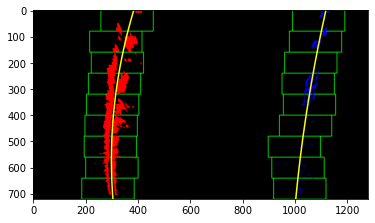

In [23]:
# Testing on a binary warped image
out_img, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_im)

plt.imshow(out_img)
# Saving output
plt.savefig('./output_images/lane_detect.jpg')
plt.show()

In [24]:
# With the left_fit and right_fit previously found we can search in the next image based on those spots
def search_around_poly(binary_warped, left_fit, right_fit, plot=True):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) < 100 or len(rightx) < 100:
        left_fitx = []
        right_fitx = []
        return None, left_fitx, right_fitx, left_fit, right_fit

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    if plot == True:
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    else:
        result = out_img.copy()
    
    return result, left_fitx, right_fitx, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

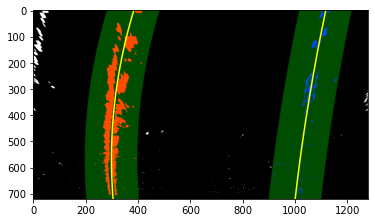

In [25]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, left_fit, right_fit = search_around_poly(warped_im, left_fit, right_fit)

# View your output
plt.imshow(result)
plt.show()

### Calculating the curvature
* Determine the curvature of the lane and vehicle position with respect to center.

In [26]:
# The function below calculates the curvature and vehicle offset using the left and right fitted polys
def measure_curvature(warped_im, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0])
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    
    ## Implement the calculation of the left line here
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    
    ## Implement the calculation of the right line here
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # As per commented by Francesco in the Mentors Help, here we can calculate the vehicle offset
    lane_center = ((left_fit[0]+right_fit[0])*warped_im.shape[0]**2+(left_fit[1]+right_fit[1])*warped_im.shape[0]+ left_fit[2] + right_fit[2])//2
    # we assume the camera is centered in the car
    car_center = warped_im.shape[1]/2
    center_offset = (lane_center - car_center) * xm_per_pix
    
    return left_curverad, right_curverad, center_offset


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad, center_offset = measure_curvature(warped_im, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm', 'vehicle offset from center', '{:.2f}'.format(center_offset), 'm')

2124.129713014228 m 8026.186185326663 m vehicle offset from center 0.06 m


### Warp back the result to the image
* Warp the detected lane boundaries back onto the original image.

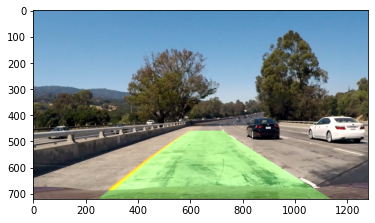

In [27]:
# Warp back
def un_warped(warped_im, img_rgb, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_rgb.shape[1], img_rgb.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_rgb, 1, newwarp, 0.3, 0)
    
    return result
    
result = un_warped(warped_im, img_rgb, left_fitx, right_fitx, Minv)
plt.imshow(result)
plt.show()

### Final Image
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

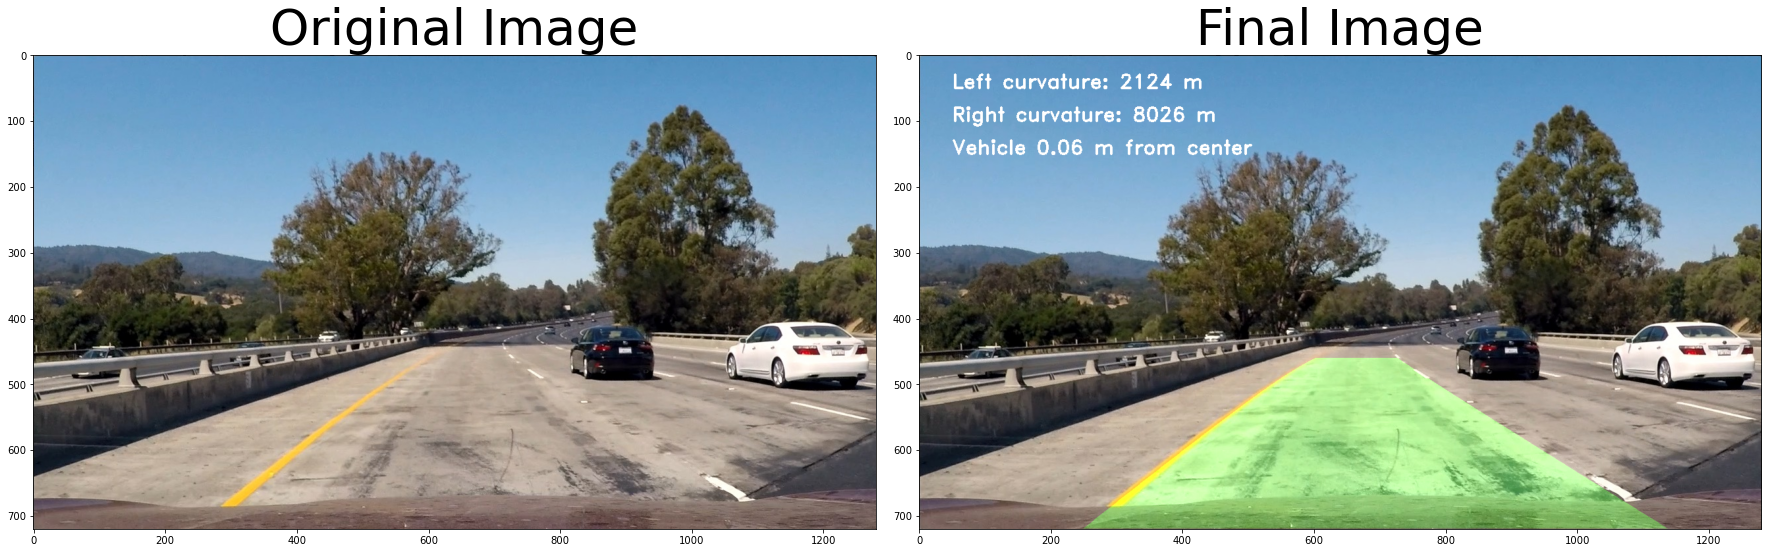

In [30]:
cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
cv2.putText(result, 'Vehicle {:.2f} m from center'.format(center_offset), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

# Plotting result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Final Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# Saving output
plt.savefig('./output_images/final_image.jpg')
plt.show()

### Creating the pipeline

In [31]:
# Adding all functions to create the pipeline that receives the image or frame and returns the final result

def full_pipeline(img, tipo='imagem'):
    
    # Undistort image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # Get binary image
    i_test = threshs(undistorted, tipo)
    b_test = pipeline_binary(undistorted, tipo)
    combined_binary = np.zeros_like(b_test)
    combined_binary[(i_test == 1) & (b_test == 1)] = 1
    
    # Warp binary image
    warped_im, Minv = warp(combined_binary)
    
    # Get lanes
    out_img, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_im, plot=False)
        
    # measure curvature
    left_curverad, right_curverad, center_offset = measure_curvature(warped_im, left_fit, right_fit)
    
    # unwarp
    result = un_warped(warped_im, undistorted, left_fitx, right_fitx, Minv)
    
    # Final_image
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle {:.2f} m from center'.format(center_offset), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    final_image = result.copy()
    
    return final_image

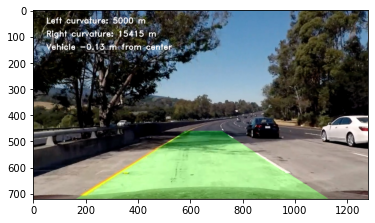

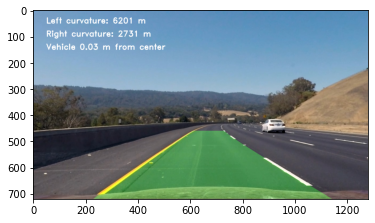

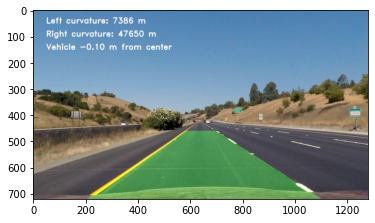

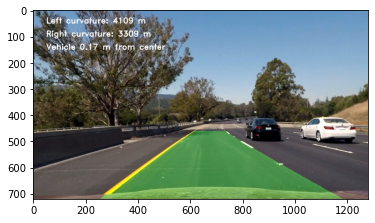

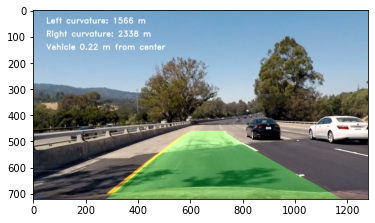

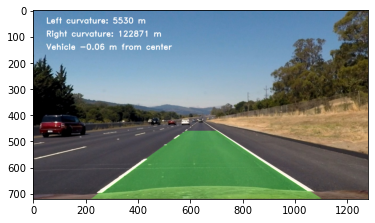

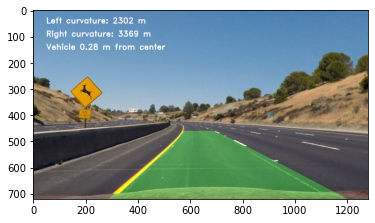

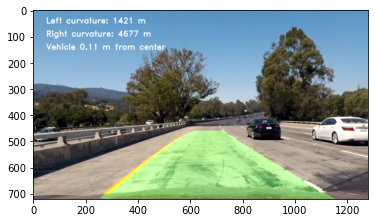

In [32]:
test_images = glob.glob('./test_images/*.jpg')

for img in test_images:
    img_bgr = cv2.imread(img)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    res = full_pipeline(img_rgb, 'video')
    plt.imshow(res)
    plt.show()

In [33]:
# Adding all functions to create the pipeline that receives the image or frame and returns the final result

# Creating the Lane class
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        self.recent_fitted = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        self.current_fitx = []
        #difference in fit coefficients between last and new fits
        self.diffs = 0

def full_pipeline(img, tipo='imagem'):
    
    # Undistort image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # Get binary image
    i_test = threshs(undistorted, tipo)
    b_test = pipeline_binary(undistorted, tipo)
    combined_binary = np.zeros_like(b_test)
    combined_binary[(i_test == 1) & (b_test == 1)] = 1
    
    # Warp binary image
    warped_im, Minv = warp(combined_binary)
    
    # Get lanes
    # if not initiated
    if lane.detected == False or lane.diffs == 0:
        out_img, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_im, plot=False)
        plt.imshow(out_img)
        plt.show()
        lane.detected = True
        lane.current_fit = [left_fit, right_fit]
        lane.current_fitx = [left_fitx, right_fitx]
        lane.recent_xfitted = [[left_fitx, right_fitx]]

    else:
        # if not initial or not found lane search around
        res_around, left_fitx, right_fitx, left_fit, right_fit = search_around_poly(warped_im, lane.current_fit[0], lane.current_fit[1], plot=False)
        if len(left_fitx) < 100 or len(right_fitx) < 100:
            out_img, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_im, plot=False)
            plt.imshow(out_img)
            plt.show()
            lane.current_fit = [left_fit, right_fit]
            lane.current_fitx = [left_fitx, right_fitx]
            lane.recent_xfitted = [[left_fitx, right_fitx]]
            lane.detected = False
        else:
            lane.current_fitx = [left_fitx, right_fitx]
            lane.current_fit = [left_fit, right_fit]
            lane.recent_xfitted.append([left_fitx, right_fitx])
            
    lane.diffs = ((left_fit[0]-right_fit[0])*warped_im.shape[0]**2+(left_fit[1]-right_fit[1])*warped_im.shape[0]+ left_fit[2] - right_fit[2])
    
    if len(lane.recent_xfitted) > 7:
        lane.recent_xfitted.pop(0)
        
    lane.best_fit = np.array(lane.recent_xfitted).mean(axis=0)
        
    # measure curvature
    left_curverad, right_curverad, center_offset = measure_curvature(warped_im, lane.current_fit[0], lane.current_fit[1])
    
    # unwarp
    result = un_warped(warped_im, undistorted, lane.best_fit[0], lane.best_fit[1], Minv)
    
    # Final_image
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle {:.2f} m from center'.format(center_offset), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    final_image = result.copy()
    
    return final_image

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).

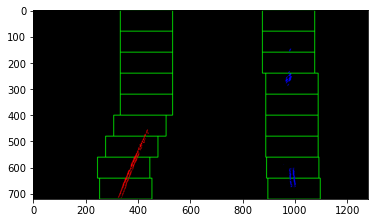

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to target thread (0x5603fc9ad180)

QObject::moveToThread: Current thread (0x5603fc9ad180) is not the object's thread (0x5603fb710de0).
Cannot move to tar

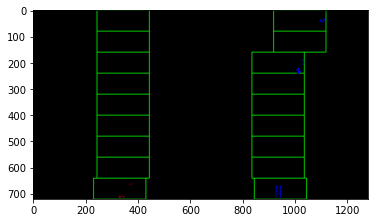

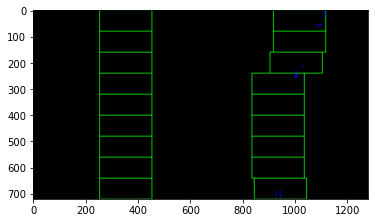

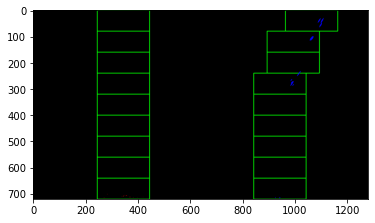

The function failed to fit a line!


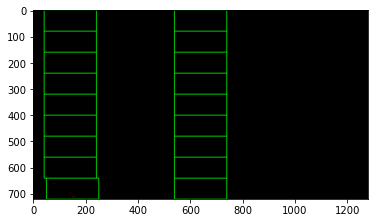

/tmp/ipykernel_481795/3145953236.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
/tmp/ipykernel_481795/3145953236.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


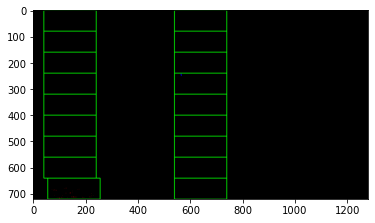

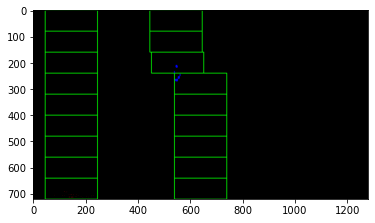

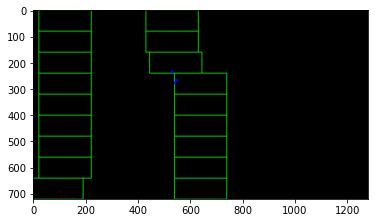

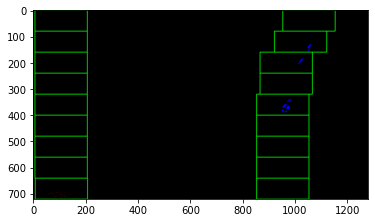

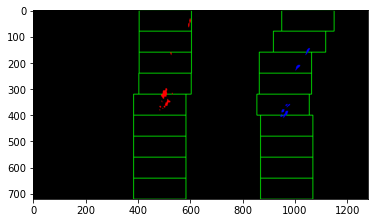

In [35]:
# Visualizing the video and saving
cap = cv2.VideoCapture("challenge_video.mp4")
lane = Lane()

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)

result = cv2.VideoWriter('challenge_video_output.mp4', 
                         cv2.VideoWriter_fourcc(*'MP4V'),
                         20, size)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:

        cv2.imshow('Frame',frame)
        res = full_pipeline(frame, tipo='video')
        
        cv2.imshow('Result',res)
        result.write(res)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
result.release()

cv2.destroyAllWindows()